<a href="https://colab.research.google.com/github/Robotmurlock/MATF-ML-pix2pix-CycleGAN/blob/main/01-pix2pix/mnist-long.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Osnova za ovu svesku je [pix2pix rad](https://arxiv.org/pdf/1611.07004.pdf) i [pix2pix tensorflow tutorijal](https://www.tensorflow.org/tutorials/generative/pix2pix).

# Generativni model

Jedna od osnovnih podela modela nadgledanog učenja (probabalističkih) je na **diskriminativne** i **generativne** modele. Diskriminativni modeli modeluju uslovnu raspodelu **p(y|x)** tj. zavisnost ciljne promenljive **y** na osnovu atributa **x**. Za ovaj tip modela nije potrebna uopštena veza između svih atributa. Sa druge strane,
generativni modeli modeluju raspodelu **p(x)** tj. svih atributa **x**. Aproksimacija te raspodele je nam nudi značajno veće informacije i lako možemo da izrazimo **p(y|x)** ako nam je to neophodno. 

Modelovanje zajedničke raspodele je teže i zahteva više podataka. Ukoliko nam ona nije neophodna, lakše je da se koristi diskriminativni model.

# Generativne suparničke mreže (GAN)

**Generativne suparničke mreže (GAN)** nam nude metod za estimaciju generativnih model koja se zasniva na isprepletanom treniranju dva modela:
- **Generator G (generativni model):** Modeluje raspodelu stvarnih podataka.
- **Diskriminator D (diskrimitivni model):** Modeluje raspodelu da je podatak stvaran ili generisan.

Modeli se treniraju sa ciljem da model G maksimizuje verovatnoću da model D napravi grešku.

## Definicija problema

Da bi generator G naučio raspodelu podataka $p_g$ podataka $x$ k oristi se šum $z$ (latentni prostor) koji se preslikava u skup podataka $G(z;\theta_g)$, gde je G diferencijabilna funkcija (ovo nam omogućava da koristimo gradijentni spust za pronalazak globalnom minimuma problema) i $\theta_g$ skup vrednosti parametara modela G. Takođe definišemo diskriminator D koji modeluje verovatnoću $D(x, \theta_d)$ da je podatak stvaran ili generisan. Odavde je jasno da:
- Model G želi da minimizuje (1 - D(G(z))), a
- Model D želi da maksimizuje D(x).

Ova dva modela međusobno igraju min-max igru, jer da bi se G želi da D što više pogreši, a D želi da što više pogodi. Optimizacioni problem $V(G, D)$ se onda definiše kao: 

$min_G max_D L_{GAN}(G, D) = E$<sub>x</sub>$[log(D(x))] + E$<sub>z</sub>$[log(1-D(G(z)))]$. 

U praksi se često maksimizuje $D(G(z))$ umesto da se minimizuje $(1 - D(G(z)))$, zbog loših performansi modela G u početnim iteracija gde je druga verzija prikladnija za gradijente. Takođe je neophodno da se oba modela treniraju uporedo, jer ako se npr. trenira prvo model D do optimalnosti, pa onda model G, dolazi do preprilagođavanja.

![gan1](images/gan1.png)

Na slici iznad vidimo primer uspešnog treniranja kroz par iteracija:
- a) Model G ne aproksimira dobro raspodelu i model D loše razlikuje tipove podataka (početak treniranja).
- b) Model D je naučio da razlikuje stvarne i generisane podatke.
- c) Model G je naučio bolje da aproksimira raspodelu podataka.
- d) Model G je naučio da aproksimira raspodelu podataka, model D ne može da razlikuje stvarne i generisane podatke. Ovo se dešava u slučaju $p_g$ = $p_{data}$, gde oba modela ne mogu da napreduju.


# Uslovljenje generativne suparničke mreže (cGAN)

Klasični GAN modeli generišu izlaz $y$ na osnovu nekog šuma $z$ tj. generator je oblika $G:z \rightarrow y$. Uslovljeni GAN model uzimaju u obzir i ulaz **x** pored šuma **z** tj. generator je oblika $G:x,z \rightarrow y$. Neophodno je da kao deo ulaza ostane neka vrsta šuma. Bez $z$ je model i dalje u mogućnosti da izvrši preslikavanje iz x u y, ali u tom slučaju je istreniran model deterministički i nije u mogućnosti da modeluje raspodelu. Šum se može dodavati u obliku slučajne promenljive sa normalnom raspodelom ili preko metode izostavljanja neurona (Dropout), ili nešto treće.

Na slici ispod je data vizualizacija učenja uslovljenje generativne mreže:
- Na osnovu ulaza x se generiše slika G(x);
- Generisana slika G(x) i ulaz x predstavljaju ulaz u model D koji dedukuju da li se radi o pravoj slici;
- Analogno prethognom koraku isto se radi i sa y umesto G(x).

![cgan1](images/cgan1.png)

## Definicija problema

Optimizacioni problem se definiše analogno običnom GAN-u. Razlika je u tome što se sada uzima u obzir i $x$ (ulaz) i $y$ (izlaz)

$min_G max_D L_{cGAN}(G, D) = E$<sub>x,y</sub>$[log(D(x, y))] + E$<sub>z</sub>$[log(1-D(x, G(x, z)))]$. 

# Framework pix2pix

Metoda **pix2pix** predstavlja opštu metodu za preslikavanje slike u sliku zasnovana na GAN modelima. Problemi koje pix2pix rešava uglavnom mogu da se reše osmišljavanjem specifičnog algoritma. Prednost korišćenja GAN modela u ovakvim problemima što se funkcija greške takođe uči tokom treniranja. Idealno je kad možemo da na visokom nivou definišemo problem kao "Generisane slike ne smeju da se razlikuju od stvarnih" i da onda model nauči funkciju greške na osnovu toga.

## U-Net

Za generator može da se koristi enkoder-dekoder arhitektura. Za pix2pix se koristi U-Net, modifikovana verzija enkoder-dekoder arhitekture sa preskočenim vezama simetričnih slojeva. Motivacija za korišćenje ove arhitekture je da problemi na koje je pix2pix skoncentrisan se odnosi na preslikavanje između slika pri čemu se one razlikuju po izgledu, a struktura tih slika ima je slična. U tom slučaju je poželjno da se neke informacije "prebace" sa ulaza na izlaz.

![unet](images/unet.png)

## PatchGAN

Diskriminator ne mora nužno da uzima samo celu sliku u obzir i klasifikuje nju kao generisanu ili stvarnu, jer umesto toga može da klasifikuje delove slike (Patch) dimenzije pod pretpostavkom nezavisnosti piksela koji su udaljeni za bar jedan dijametar dela slika (Patch). Prednost ovog pristupa je manji broj parametara i bolje performanse. Na slici ispod se nalazi poređenje različitih dimenzija delova slika (Patch) i njihovih rezultata. Sa manjom dimenzijom prozora se podstiče veći diverzitet boja, a sa većim dimenzijama prozora se dobija bolji kvalitet slike.

![unet](images/patchgan1.png)

# L1/L2 greška

Dodavanjem L1 ili L2 greške na grešku generatora menjamo njegov zadatak koji sada podrazumeva prevaru diskriminatora (kao i prethodno) i sličnost rezultata sa originalnim slikama u L1 ili L2 smislu. Tada problem postaje:

$min_G max_D L_{cGAN}(G, D) + \lambda L_{Lp}$. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from typing import Tuple
from dataclasses import dataclass
from datetime import datetime
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

from PIL import Image
from IPython import display

In [2]:
# Parametri okruzenja
MASTER_FOLDER = 'pix2pix' # Folder gde se cuvaju svi rezultati
BATCH_SIZE = 40 
IMG_SIZE = 32 # Pozeljno je da dimenzija slike bude stepen dvojke zbog U-NET modela
IMG_CHANNELS = 1
SKUP_PODATAKA = 'mnist' # 'fashion_mnist'

## Priprema skupa podataka
Kao osnova za podatke se koristi `mnist` skup podataka. Skup podataka za treniranje se formira tako što na svaku sliku dodaje na nasumičnom mestu u centru sivi pravougaonik koji prekriva taj deo slike. Cilj je da napravimo cGAN model koji može da prepozna kako da ukloni taj pravougaonik.

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np


def load_data(dataset_name: str):
    """
    Pomocna funkcija za ucitavanje MNIST skupa podataka
    :param dataset_name: Ime skupa podataka. U opticaju su
        - 'mnist'
        - 'fashion_mnist'
    :return: Skup podataka za ucenje i testiranje
    """
    assert dataset_name in ['mnist', 'fashion_mnist']
    (tf_train, tf_test), ds_info = tfds.load(
        dataset_name,
        split=['train', 'test'],
        shuffle_files=True,
        as_supervised=False,
        with_info=True,
    )
    return tf_train, tf_test


# Obrada podataka
def create_mnist_input(img, radius=4):
    """
    Posto su tenzori imutabilni (Osim ako se ne koristi Variable),
    u ovom slucaju se slika deli na 5 delova u odnosu na deo slike koji se brise
    1. Deo slike koji se brise tj. postavlja se sivi kvadrat
    2. Deo slike levo od kvadrata
    3. Deo slike desno od kvadrata
    4. Deo slike iznad kvadrata
    5. Deo slike ispod kvadrata
    2 2 2 4 4 3
    2 2 2 4 4 3
    2 2 2 4 4 3
    2 2 2 1 1 3
    2 2 2 1 1 3
    2 2 2 4 4 3

    Kvadrat se ne postavlja na ivicama kako bi zadatak bio nesto tezi
    (model bi lako naucio da ivice uvek popuni crnom bojom jer se tu ne nalaze brojevi).

    Alternativa bi bila da se podaci pretprocesiraju koriscenjem numpy.

    :param img: Slika
    :param radius: Radijus kvadrata, polovina stranice
    :return: Slika sa kvadratom
    """
    img_input = tf.identity(img)
    x_coord = np.random.randint(max(radius, 8), min(img.shape[0]-8, img.shape[1]-radius))
    y_coord = np.random.randint(max(radius, 8), min(img.shape[0]-8, img.shape[1]-radius))

    img_input_left = img_input[:x_coord-radius, :, :]
    img_input_right = img_input[x_coord+radius:, :, :]
    img_input_top = img_input[x_coord-radius:x_coord+radius, :y_coord-radius, :]
    img_input_bottom = img_input[x_coord-radius:x_coord+radius, y_coord+radius:, :]
    img_input_center = tf.ones(shape=(2*radius, 2*radius, 1)) * 128
    img_input_bottom_center_top = tf.concat([img_input_top, img_input_center, img_input_bottom], axis=1)
    img_input = tf.concat([img_input_left, img_input_bottom_center_top, img_input_right], axis=0)

    return img_input, img


def tf_pipeline(tf_dataset, img_size: int, batch_size: int):
    """
    Funkcija za pripremu MNIST skupa podataka.
    Skup se prvenstveno konvertuje u odgovarajuci oblik,
    onda se dodaje sum na podatke (pogledati rad), i na
    kraju se skup priprema za obradu (skaliranje, mesanje i podela na batch-eve)

    :param tf_dataset: Skup podataka
    :param img_size: Dimenzija slike (odnosi se na izlaz)
    :param batch_size: Dimenzija batch-a
    :return: Pripremljen skup podataka
    """
    # noinspection PyUnresolvedReferences
    rotation = layers.RandomRotation(factor=(-0.1, 0.1))

    # Konvertovanje ulaza u sliku dimenzije [img_size]x[img_size]
    tf_dataset = tf_dataset.map(lambda x: tf.cast(x['image'], tf.float32))
    tf_dataset = tf_dataset.map(lambda x: tf.image.resize(x, (img_size, img_size), method='nearest'))

    # Dodavanje nasumicne "beline" na sliku
    tf_dataset = tf_dataset.map(create_mnist_input)
    
    # Neophodno je da postoji neka vrsta suma
    tf_dataset = tf_dataset.map(lambda x, y: (rotation(x), y))

    # Pikseli sa normalizuju na interval [0, 1]
    tf_dataset = tf_dataset.map(lambda x, y: (x / 255.0, y / 255.0))
    tf_dataset = tf_dataset.shuffle(100)
    tf_dataset = tf_dataset.batch(batch_size)
    return tf_dataset


def prepare_mnist_dataset(dataset_name: str, img_size: int = 32, batch_size: int = 40):
    """
    Ucitavavanje i priprema MNIST skupa podataka.
    
    :param dataset_name: Ime skupa podataka ('fashion_mnist' ili 'mnist')
    :param img_size: Dimenzija slike u podacima
    :param batch_size: Dimenzija 'Batch'-a
    :return: Skup podataka za ucenje i skup podataka za testiranje
    """
    tf_train, tf_test = load_data(dataset_name)
    tf_train = tf_pipeline(tf_train, img_size, batch_size)
    tf_test = tf_pipeline(tf_test, img_size, batch_size)
    return tf_train, tf_test

tf_train, tf_test = prepare_mnist_dataset('mnist')

In [4]:
def show_image(img: tf.Tensor, title=None, img_size=None) -> None:
    """
    Pomocna funkcija za prikazivanja slika

    :param img: Slika koja treba da se prikaze
    :param title: Naslov koji ide uz sliku (opciono)
    :param img_size: Dimenzija slike (opciono)
    :return: None
    """
    fig, ax = plt.subplots(figsize=(6, 4))
    if img_size is not None:
        img = tf.reshape(img, shape=(img_size, img_size))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(title)
    plt.show()

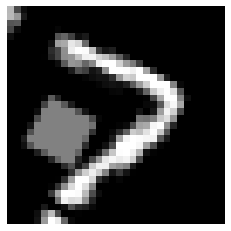

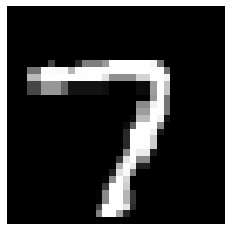

In [5]:
# Provera obradjenog skupa podataka
for x, y in tf_train.take(1):
    assert x.shape == (BATCH_SIZE, IMG_SIZE, IMG_SIZE, 1)
    show_image(x[4])
    show_image(y[4])

In [6]:
def n_power2(n: int) -> int:
    """
    Pomocna funkcija izracunava stepen dvojke u broju.
    """
    result = 0
    while n % 2 == 0:
        result += 1
        n /= 2
    return result


def downsample(n_filters: int, kernel_size: int, apply_batchnorm: bool = True, name: str = None):
    """
    Pomocna funkcija za konstrukciju enkodera.

    Osnovna jedinica enkodera koja se koristi za Generator tj. U-Net arhitekturu i za Diskriminator.
    Sastoji se iz konvolutivnog sloja, opcionalnog sloja za unutrasnju standardizaciju i propustajuceg ReLU sloja.
    :param n_filters: Broj filtera konvolutivnog sloja mreze
    :param kernel_size: Dimenzija kernela
    :param apply_batchnorm: Da li se koristi unutrasnja standardizacija
    :param name: Ime modela (za vizualizaciju arhitekture)
    :return: Jednoslojni model: Izlaz je duplo manji od ulaza zbog koraka dimenzije 2.
    """
    model = keras.Sequential(name=name)
    model.add(layers.Conv2D(n_filters, kernel_size, strides=2, padding='same', use_bias=False))
    if apply_batchnorm:
        model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    return model


class UNetGeneratorBuilder:
    """
    Pomocna klasa za Konstrukciju generatora sa U-NET arhitekturom.

    :param input_size: Dimenzija slike ulaza.
    :param output_channels: Broj kanala generisane slike
    """

    def __init__(self, input_size: int, output_channels: int):
        self.input_size = input_size
        self.output_channels = output_channels

        self._encoder_layers = []
        self._encoder_layer_next_id = 1

        self._decoder_layers = []
        self._decoder_layer_next_id = 1

        self._locked = False

    def add_downsample_layer(self, n_filters: int, kernel_size: int, apply_batchnorm: bool = True):
        """
        Okvir za "downsample" funkciju koji dodeljuje odgovarajuce ime sloju.
        """
        self._encoder_layers.append(
            downsample(n_filters, kernel_size, apply_batchnorm, f'downsample{self._encoder_layer_next_id}'))
        self._encoder_layer_next_id += 1

    def add_upsample_layer(self, n_filters: int, kernel_size: int, apply_dropout: bool = False):
        """
        Analogno "add_downsample_layer" za dekoder.
        :param n_filters: Broj filtera transponovanog konvolutivnog sloja mreze
        :param kernel_size: Dimenzija kernela
        :param apply_dropout: Da li se koristi izostavljanje
        :return: Jednoslojni model: Izlaz je duplo veci od ulaza zbog koraka dimenzije 2.
        """
        model = keras.Sequential(name=f'upsample{self._decoder_layer_next_id}')
        self._decoder_layer_next_id += 1

        model.add(layers.Conv2DTranspose(n_filters, kernel_size, strides=2, padding='same', use_bias=False))
        if apply_dropout:
            model.add(layers.Dropout(0.5))
        model.add(layers.LeakyReLU())
        self._decoder_layers.append(model)

    def build(self):
        """
        Koraci generisanja modela:
        1. Provera se da li definisani slojevi enkodora i dekodera imaju smisla
            (da li ispunjavaju uslove za konstrukciju)
        2. Formira model sa spajanjem suprotnih veza
          Prvi sloj enkodera se spaja sa poslednjim slojem dekodera
          Drug sloj enkodera se spaja sa pretposlednjim sloje dekodera
          ...
          Poslednji sloj enkodera se spaja direktno sa prvim slojem dekodera, pa ne treba dodatno spajanje.
        :return: Generator sa U-Net arhitekturom
        """
        assert len(self._decoder_layers) + 1 == len(self._encoder_layers)
        assert len(self._decoder_layers) <= n_power2(self.input_size)

        inputs = layers.Input(shape=[self.input_size, self.input_size, 1], name='input')
        x = inputs

        # Encoder
        skips = []
        for down in self._encoder_layers:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])

        # Decoder (and skips)
        for up, skip in zip(self._decoder_layers, skips):
            x = up(x)
            x = layers.Concatenate()([x, skip])

        # Sa sigmoid aktivacionom funkcijom preslikavamo izlaz na [0, 1] interval
        final_layer = layers.Conv2DTranspose(self.output_channels, 3, strides=2, padding='same', activation='sigmoid')
        x = final_layer(x)

        return keras.Model(inputs=inputs, outputs=x)

In [7]:
def create_generator(*args, **kwargs):
    generator_builder = UNetGeneratorBuilder(*args, **kwargs)
    generator_builder.add_downsample_layer(16, 3, apply_batchnorm=True)
    generator_builder.add_downsample_layer(32, 3)
    generator_builder.add_upsample_layer(16, 3, apply_dropout=True)
    return generator_builder.build()

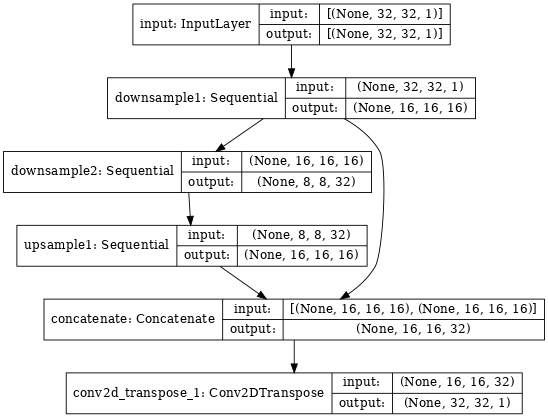

In [8]:
generator = create_generator(input_size=IMG_SIZE, output_channels=IMG_CHANNELS)
keras.utils.plot_model(generator, show_shapes=True, dpi=64)

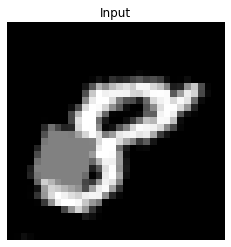

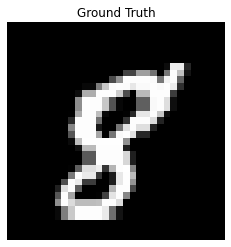

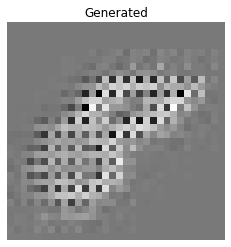

In [9]:
# Testiranje Generatora
for x, y in tf_train.take(1):
    show_image(x[0], title='Input')
    show_image(y[0], title='Ground Truth')
    show_image(generator(x)[0], title='Generated')

In [10]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target, alpha=1, loss_func=None):
    if loss_func is None:
        loss_func = bce

    # Kaznjava se Generator za svaku pogodjenu sliku Diskriminatora
    # Idealno za Generator je da Diskriminator kaže da su sve prave slike tj. jedinice.
    gan_loss = loss_func(tf.ones_like(disc_generated_output), disc_generated_output)
    # Dodaje se L1 greska kako bi se forsiralo da slike izgledaju vise kao obicne
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    # 'alpha' parametar nam omogucava akcentovanja na neku od gresaka
    total_gen_loss = gan_loss + (alpha * l1_loss)
    return total_gen_loss, gan_loss, alpha * l1_loss

In [11]:
def create_discriminator(input_size: int):
    """
    Diskriminator se sastoji iz niza "downsample" slojeva.
    Napomena: Diskriminator ocenjuje nekoliko ravnomerno rasporedjenih kvadrata na slici
    i za svaki govori da li je slika prava ili ne. 

    :param input_size: Dimenzija ulazne slike
    :return: Diskriminator
    """
    inputs = layers.Input(shape=[input_size, input_size, 1], name='disc_input')
    target = layers.Input(shape=[input_size, input_size, 1], name='disc_target')

    x = layers.concatenate([inputs, target])

    x = downsample(16, 4, apply_batchnorm=False)(x)
    x = downsample(32, 4)(x)
    x = layers.Conv2D(1, 5, strides=1)(x)

    return keras.Model(inputs=[inputs, target], outputs=x)

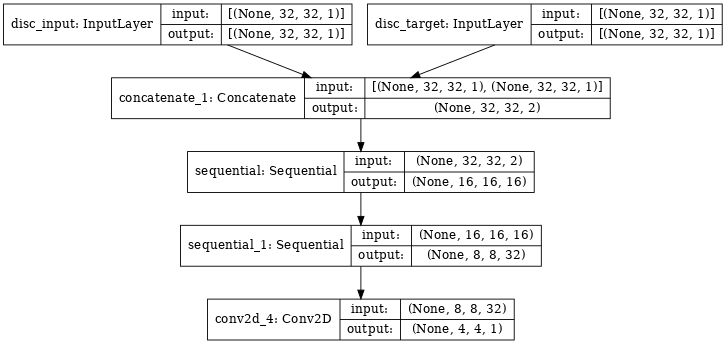

In [12]:
discriminator = create_discriminator(input_size=IMG_SIZE)
keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [13]:
# Testiranje diskriminatora
result = None
for x, y in tf_train.take(1):
    result = discriminator([x, y])
result.shape

TensorShape([40, 4, 4, 1])

In [14]:
def discriminator_loss(disc_generated_output, real_output, loss_func=None):
    if loss_func is None:
        loss_func = bce
    
    # Kaznjava se Diskriminator za svaku nepogodjenu pravu sliku
    real_loss = loss_func(tf.ones_like(real_output), real_output)
    # Kaznjava se Diskriminator za svaku pogodjenu "laznu" sliku
    generated_loss = loss_func(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + generated_loss

In [15]:
# Podesavanje optimizatora 
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [16]:
# Podesavanje parametara za periodicnog cuvanja stanja modela
checkpoint_dir = f'{MASTER_FOLDER}/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator)

In [17]:
def test_image_generation(gen_model, input_batch, target_batch, img_size, rows=3):
    """
    Pomocna funkcija za vizualizaciju perfomansi modela.
    :param gen_model: Generator
    :param input_batch: Ulaz (slike sa postavljenim kvadratom)
    :param target_batch: Izlaz (prave slike)
    :param img_size: Dimenzija slike koja se prikazuje
    :param rows: Broj primera koji se prikazuju
    :return: None
    """
    assert rows <= input_batch.shape[0]
    prediction_batch = gen_model(input_batch, training=True)

    fig, axs = plt.subplots(figsize=(18, 3 * rows), ncols=3, nrows=rows)
    for i in range(rows):
        p_img = prediction_batch[i]
        i_img = input_batch[i]
        t_img = target_batch[i]
        for j, (img, title) in enumerate([(i_img, 'Input'), (t_img, 'Target'), (p_img, 'Prediction')]):
            axs[i][j].imshow(tf.reshape(img, shape=(img_size, img_size)), cmap='gray')
            axs[i][j].set_title(title)
            axs[i][j].axis('off')
    plt.show()

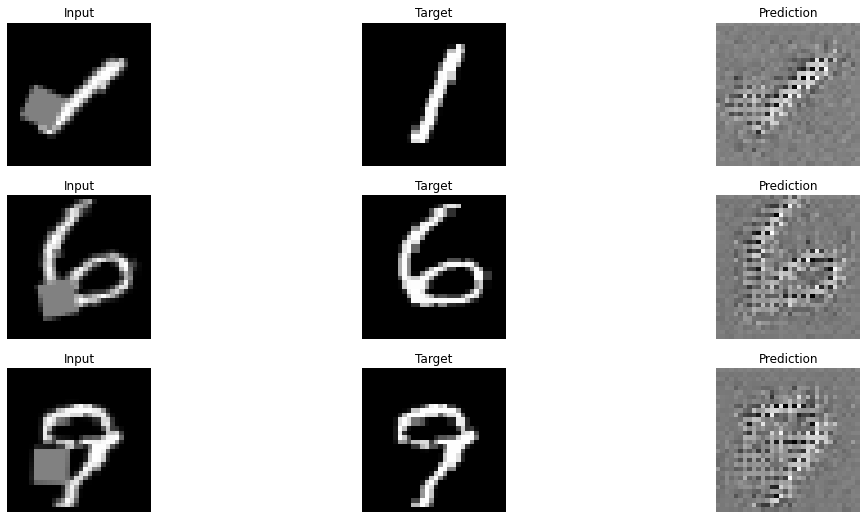

In [18]:
# Testiranje funkcije "test_image_generation"
for x, y in tf_train.take(1):
    test_image_generation(generator, x, y, IMG_SIZE)

In [19]:
# Podesavanje logovanja
summary_writer = tf.summary.create_file_writer(f'{MASTER_FOLDER}/logs/fit/{datetime.now().strftime("%Y%m%d-%H%M%S")}')

In [20]:
class CGAN:
    def __init__(self,
                 generator,
                 discriminator,
                 alpha, 
                 generator_optimizer,
                 discriminator_optimizer,
                 summary_writer=None,
                 checkpoint=None,
                 checkpoint_prefix=None
                 ):
        """
        :param generator: Generator model
        :param discriminator: Diskriminator model
        :param alpha: Parametar za odnos izmedju GAN i L1 greske kod generator modela
        :param generator_optimizer: Optimizator za generator
        :param discriminator_optimizer: Optimizator za diskriminator
        :param summary_writer: Pomocni objekat za logovanje
        :param checkpoint: Pomocni objekat za cuvanje modela
        :param checkpoint_prefix: Putanja gde se cuva "checkpoint"
        """
        self.generator = generator
        self.discriminator = discriminator
        self.alpha = alpha
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

        self.summary_writer = summary_writer
        self.checkpoint = checkpoint
        self.checkpoint_prefix = checkpoint_prefix
        if self.checkpoint_prefix is None:
            self.checkpoint_prefix = '.'

    @tf.function
    def train_step(self, input_image, target, step):
        """
        Za svaki korak ucenja se vrsi vise operacija:
        1. Generator generise izlaz na osnovu ulaza
        2. Diskriminator ocenjuje stvarne slike (da li su prave ili ne)
        3. Diskriminator ocenjuje generisane slike (da li su prave ili ne)
        4. Odredjuje se greska Generatora na osnovu ocene Diskriminatora (da li je prevara uspesna) iz koraka #3
          i na osnovu stvarne slike (L1 greska)
        5. Odredjuje se greska Diskriminatora na osnovu ocena iz koraka #2 i #3

        :param input_image: Ulaz generatora
        :param target: Prava slika
        :param step: Broj trenutnog koraka
        :return: Loss
        """
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # 1
            gen_output = self.generator(input_image, training=True)
            # 2
            disc_real_output = self.discriminator([input_image, target], training=True)
            # 3
            disc_generated_output = self.discriminator([input_image, gen_output], training=True)
            # 4
            gen_total_loss, gen_gan_loss, gen_l1_loss = \
                generator_loss(disc_generated_output, gen_output, target, alpha=self.alpha)
            # 5
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        generator_gradients = gen_tape.gradient(gen_total_loss, self.generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(
            zip(generator_gradients, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(
            zip(discriminator_gradients, self.discriminator.trainable_variables))

        if self.summary_writer is not None:
            with self.summary_writer.as_default():
                tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
                tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
                tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
                tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

        return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

    def eval_step(self, input_image, target):
        """
        Evaluira rezultate za dati ulaz
        :param input_image: Ulaz generatora
        :param target: Prava slika
        :return: Loss
        """
        gen_output = self.generator(input_image)
        disc_real_output = self.discriminator([input_image, target])
        disc_generated_output = self.discriminator([input_image, gen_output])
        gen_total_loss, gen_gan_loss, gen_l1_loss = \
            generator_loss(disc_generated_output, gen_output, target, alpha=self.alpha)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

    def fit(self,
            train_ds,
            val_ds,
            steps,
            test_generation_period=1000,
            n_test_examples=4,
            img_size=32,
            checkpoint_period=5000):
        """
        Napomena: Namera je da se funkcija koristi u okviru IPython sveske

        Proces ucenja zasnovan na funkciji "train_step" koji dodatno:
        - prikazuje rezultate;
        - ispisuje stanje ucenja;
        - Kreira periodicno checkpoint.

        :param train_ds: Skup za treniranje
        :param val_ds: Skup za validaciju
        :param steps: Broj koraka treniranja
        :param test_generation_period: Broj koraka izmedju vizualizacije novih rezultata
        :param n_test_examples: Broj instanci koje se vizualizuju
        :param img_size: Dimenzija slike koja se prikazuje u primerima
        :param checkpoint_period: Period za cuvanje rezultata
        :return: Loss History
        """
        train_history, val_history = [], []
        dot_period = test_generation_period // 10

        example_input, example_target = next(iter(val_ds.take(n_test_examples)))
        start = time.time()

        for step, (input_image, target) in train_ds.repeat().take(steps+1).enumerate():
            if (step+1) % test_generation_period == 0:
                display.clear_output(wait=True)

                if step != 0:
                    print(f'Time taken for {step+1} steps: {time.time()-start:.2f} sec\n')

                start = time.time()

                test_image_generation(
                    self.generator, example_input, example_target, rows=n_test_examples, img_size=img_size)
                print(f"Step: {step+1}")

                for val_input_image, val_target in val_ds:
                    val_history.append(self.eval_step(val_input_image, val_target))

            train_history.append(self.train_step(input_image, target, step))

            # Training step
            if (step+1) % dot_period == 0:
                print('.', end='', flush=True)

            # Save (checkpoint) the model every 5k steps
            if self.checkpoint is not None and (step + 1) % checkpoint_period == 0:
                self.checkpoint.save(file_prefix=self.checkpoint_prefix)

        return train_history, val_history

Time taken for 5000 steps: 88.95 sec



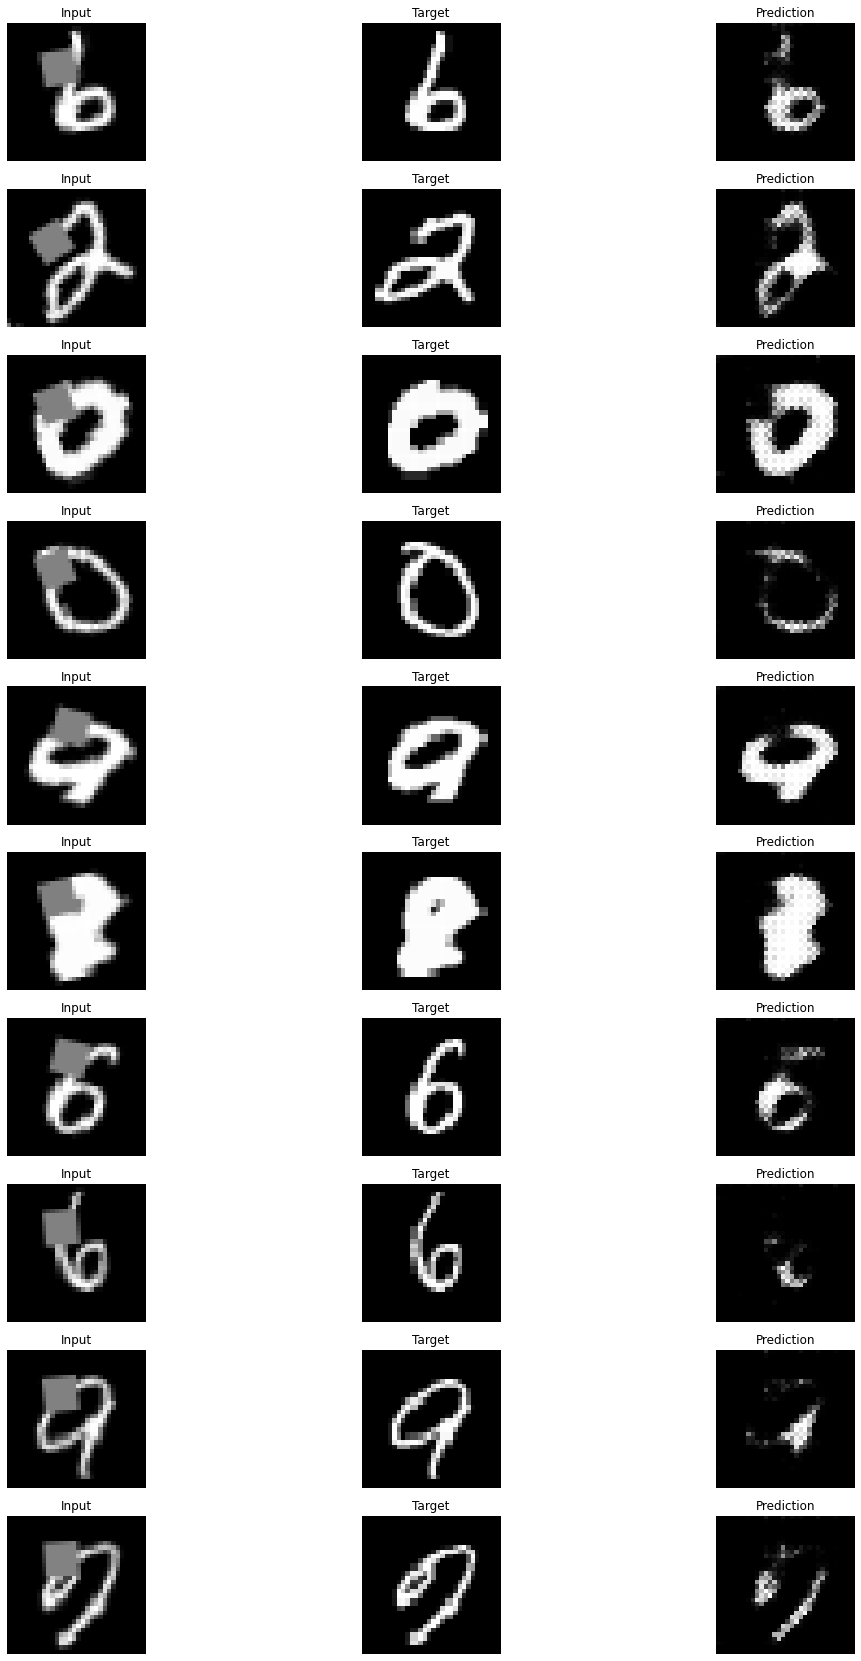

Step: 5000
.

In [21]:
cgan = CGAN(
  generator=generator,
  discriminator=discriminator,
  alpha=5,
  generator_optimizer=generator_optimizer,
  discriminator_optimizer=discriminator_optimizer,
  summary_writer=summary_writer,
  checkpoint=checkpoint,
  checkpoint_prefix=checkpoint_prefix
)
train_history, val_history = cgan.fit(tf_train, tf_test, steps=5000, test_generation_period=1000, n_test_examples=10)

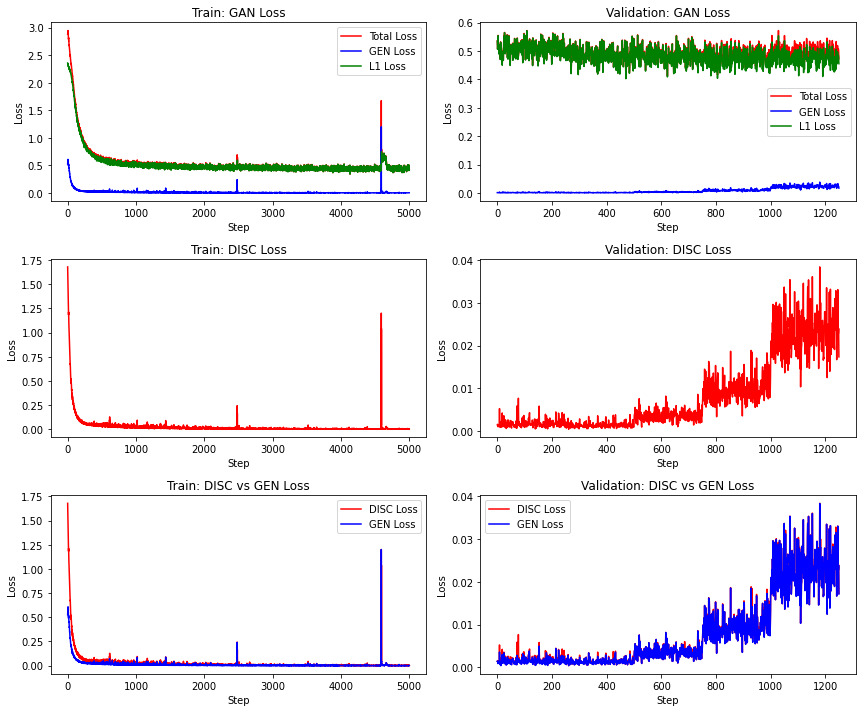

In [22]:
# Prikazivanje rezultata na skupu za treniranje i validaciju/testiranje
def plot_history(history, axs, col, prefix=''):
    """
    :param history: Istorija funkcije greske
    :param axs: Grafice nad kojim se slika
    :param col: Kolona koja se popunjava (ako ima vise skupova, moze da se gleda uporedo rezultat)
    :param prefix: Prefiks za rezultat u izabranoj koloni
    """
    gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss = zip(*history)
    axs[0][col].plot(gen_total_loss, color='red', label='Total Loss')
    axs[0][col].plot(gen_gan_loss, color='blue', label='GEN Loss')
    axs[0][col].plot(gen_l1_loss, color='green', label='L1 Loss')
    axs[0][col].set_title(f'{prefix} GAN Loss')
    axs[0][col].set_xlabel('Step')
    axs[0][col].set_ylabel('Loss')
    axs[0][col].legend()

    axs[1][col].plot(disc_loss, color='red')
    axs[1][col].set_title(f'{prefix} DISC Loss')
    axs[1][col].set_xlabel('Step')
    axs[1][col].set_ylabel('Loss')

    axs[2][col].plot(disc_loss, color='red', label='DISC Loss')
    axs[2][col].plot(gen_gan_loss, color='blue', label='GEN Loss')
    axs[2][col].set_title(f'{prefix} DISC vs GEN Loss')
    axs[2][col].set_xlabel('Step')
    axs[2][col].set_ylabel('Loss')
    axs[2][col].legend()

def plot_training_results(train_history, val_history):
    """
    Prikazuje grafike koji predstavljaju rezultate treniranja nad skupom za ucenje i nad skupom za validaciju.
    :param train_history: Istorija funkcije greske nad skupom za ucenje
    :param val_history: Istorija funkcije greske nad skupom za validaciju
    """
    fig, axs = plt.subplots(figsize=(12, 10), nrows=3, ncols=2)
    plot_history(train_history, axs, col=0, prefix='Train:')
    plot_history(val_history, axs, col=1, prefix='Validation:')
    plt.tight_layout()

plot_training_results(train_history, val_history)
plt.show()

Model posle nekoliko stotina iteracija počinje da preprilagođava (greška na skupu za validaciju se povećava). Kada se primeni 10000 iteracija (naspram 5000 koje se trenutno koriste), preprilagođavanje je još više očigledno, jer svaka iteracija posle nekog vremena ima veću grešku na skupu za validaciju. Ova pojava nestaje kada se isključi L1 greška (tj. postavi parametar alpha u `cgan` na `0`). Izbor ovog parametra je ključan za krajnje rezultate.

Ispostavlja se da je zadatak teži nego što izgleda na prvi pogled: U nekim slučajevima uspešno uklanja kvadrat, a u drugim nekim slučajevima potpuno obriše broj. U narednoj svesci je prikazan isti skup podataka, ali sa izabranim samo jednim brojem kako bi modelu bilo lakše da nauči odgovarajuću raspodelu. 